In [1]:
import numpy as np
import pandas as pd
from IPython.display import Image

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Importing data
campaign = pd.read_csv('../Data/campaign_data.csv')
coupon_item_map = pd.read_csv('../Data/coupon_item_mapping.csv')
customer_demo = pd.read_csv('../Data/customer_demographics.csv')
customer_transact = pd.read_csv('../Data/customer_transaction_data.csv')
item_data = pd.read_csv('../Data/item_data.csv')
train = pd.read_csv('../Data/train.csv')
test = pd.read_csv('../Data/test_QyjYwdj.csv')

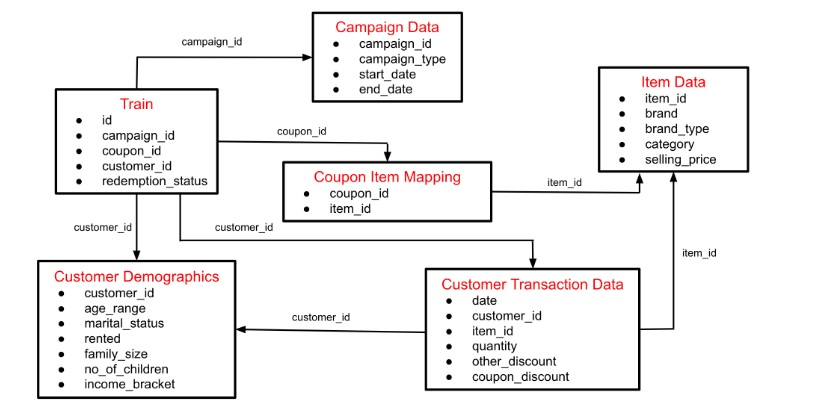

In [3]:
Image(data = '../Data/Schema_Diagram.jpg')

## Merging Data

In [4]:
coupon_item = coupon_item_map.merge(item_data, on = 'item_id').reset_index()

# Calculating number of items on which coupon is valid
item_count = coupon_item['item_id'].groupby(coupon_item['coupon_id']).count() 

# Getting dataframe unique coupon_id by aggregating based on coupon_id
coupon_item_unique = coupon_item[['coupon_id', 'brand', 'brand_type', 'category']].groupby('coupon_id').\
apply(lambda x : x.mode()).drop('coupon_id', axis = 1).reset_index(level = 0).dropna()

coupon_item_unique['items_count'] = item_count.values

# This contains item_data info and unique coupon_ids
coupon_item_unique

,coupon_id,brand,brand_type,category,items_count
0,1,1475.0,Established,Natural Products,39
0,2,2084.0,Established,Grocery,2
0,3,278.0,Established,Grocery,17
0,4,544.0,Established,Grocery,24
0,5,5357.0,Established,Pharmaceutical,7
...,...,...,...,...,...
0,1112,5177.0,Established,Grocery,6
0,1113,5184.0,Established,Pharmaceutical,15
0,1114,2416.0,Established,Pharmaceutical,3
0,1115,2446.0,Established,Grocery,7


In [5]:
customer_transact_unique = customer_transact[['customer_id', 'quantity', 'selling_price', 'other_discount', 'coupon_discount']].\
groupby('customer_id').apply(lambda x : x.mean()).drop('customer_id', axis = 1).reset_index()

# This contains mean aggregated customer_transaction info with unique customer_ids
customer_transact_unique

,customer_id,quantity,selling_price,other_discount,coupon_discount
0,1,1.170802,94.001842,-16.250382,-2.019876
1,2,1.131265,102.864033,-16.830430,-0.595084
2,3,11.578723,103.617404,-22.714227,-3.091546
3,4,1.272727,154.423727,-13.305409,-0.404773
4,5,117.869949,130.827146,-13.657917,-0.114684
...,...,...,...,...,...
1577,1578,136.790549,104.750268,-18.625581,-0.980358
1578,1579,1.511188,125.954294,-22.934570,-0.291213
1579,1580,38.689981,112.336673,-12.697278,0.000000
1580,1581,282.318812,113.925228,-14.767089,0.000000


In [6]:
customer_demo_unique = customer_demo.groupby('customer_id').\
apply(lambda x : x.mode()).drop('customer_id', axis = 1).reset_index(level = 0)

# This contains mode() aggregated customer demographics info
customer_demo_unique

,customer_id,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,1,70+,Married,0,2,NaN,4
0,6,46-55,Married,0,2,NaN,5
0,7,26-35,NaN,0,3,1,3
0,8,26-35,NaN,0,4,2,6
0,10,46-55,Single,0,1,NaN,5
...,...,...,...,...,...,...,...
0,1577,36-45,NaN,0,2,NaN,5
0,1578,46-55,Married,0,3,1,6
0,1579,46-55,NaN,0,1,NaN,4
0,1580,26-35,NaN,0,2,NaN,5


In [7]:
pd.crosstab(customer_demo_unique['marital_status'].astype(str), customer_demo_unique['family_size'].astype(str))

family_size,1,2,3,4,5+
marital_status,,,,,
Married,0,175,63,31,48
Single,65,31,11,4,3
nan,183,97,30,13,6


In [8]:
# We can fill null values in marital_status as follows : 
# for all customers having family size > 1, marital_status is married else Single
def marital_null(x):
    status, family_size = x[0], x[1]
    family_size = int(family_size[0])
    if pd.isnull(status):
        if family_size > 1:
            return 'Married'
        else:
            return 'Single'
    else:
        return status

customer_demo_unique['marital_status'] = customer_demo_unique[['marital_status', 'family_size']].\
apply(marital_null, axis = 1)

In [9]:
pd.crosstab(customer_demo_unique['no_of_children'].astype(str), customer_demo_unique['family_size'].astype(str))

family_size,1,2,3,4,5+
no_of_children,,,,,
1,0,13,94,0,0
2,0,0,10,45,0
3+,0,0,0,3,57
nan,248,290,0,0,0


In [10]:
# We can fill null values in no_of_children as follows : 
# mode of no_of_children based on family_size, one exception fill 0 where family size is 1

customer_demo_unique['no_of_children'] = customer_demo_unique[['no_of_children', 'family_size']].\
groupby('family_size').transform(lambda x : x.fillna(x.mode())).fillna('0')

In [11]:
# checking null values
customer_demo_unique.isnull().sum()

customer_id       0
age_range         0
marital_status    0
rented            0
family_size       0
no_of_children    0
income_bracket    0
dtype: int64

In [12]:
train['customer_id'].nunique(), train[train['customer_id'].isin(customer_demo['customer_id'])]['customer_id'].nunique()

(1428, 703)

In [13]:
test['customer_id'].nunique(), test[test['customer_id'].isin(customer_demo['customer_id'])]['customer_id'].nunique()

(1250, 697)

## Merging train with customer_transaction_unique, coupon_item_unique, campaign data and customer_demo_unique

In [14]:
merged_train = train.merge(campaign, on = 'campaign_id').drop('campaign_id', axis = 1).\
merge(coupon_item_unique, on = 'coupon_id').drop('coupon_id', axis = 1).\
merge(customer_transact_unique, on = 'customer_id').merge(customer_demo_unique, on = 'customer_id', how = 'left').\
drop('customer_id', axis = 1)

In [15]:
print(merged_train.shape)
print(merged_train.isnull().sum())
merged_train.head()

(78369, 19)
id                       0
redemption_status        0
campaign_type            0
start_date               0
end_date                 0
brand                    0
brand_type               0
category                 0
items_count              0
quantity                 0
selling_price            0
other_discount           0
coupon_discount          0
age_range            34708
marital_status       34708
rented               34708
family_size          34708
no_of_children       34708
income_bracket       34708
dtype: int64


,id,redemption_status,campaign_type,start_date,end_date,brand,brand_type,category,items_count,quantity,selling_price,other_discount,coupon_discount,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,1,0,X,19/05/13,05/07/13,1105.0,Established,Grocery,125,340.487097,184.260484,-33.168935,-0.287258,46-55,Single,0.0,1,0,5.0
1,89723,0,X,19/05/13,05/07/13,967.0,Established,Grocery,134,340.487097,184.260484,-33.168935,-0.287258,46-55,Single,0.0,1,0,5.0
2,121392,0,X,19/05/13,05/07/13,56.0,Local,Grocery,7,340.487097,184.260484,-33.168935,-0.287258,46-55,Single,0.0,1,0,5.0
3,68170,0,X,19/05/13,05/07/13,56.0,Established,Grocery,4947,340.487097,184.260484,-33.168935,-0.287258,46-55,Single,0.0,1,0,5.0
4,62458,0,X,19/05/13,05/07/13,56.0,Local,Natural Products,9,340.487097,184.260484,-33.168935,-0.287258,46-55,Single,0.0,1,0,5.0


## Merging test with customer_transaction_unique, coupon_item_unique, campaign data and customer_demo_unique

In [16]:
merged_test = test.merge(campaign, on = 'campaign_id').drop('campaign_id', axis = 1).\
merge(coupon_item_unique, on = 'coupon_id').drop('coupon_id', axis = 1).\
merge(customer_transact_unique, on = 'customer_id').merge(customer_demo_unique, on = 'customer_id', how = 'left').\
drop('customer_id', axis = 1)

In [17]:
print(merged_test.shape)
print(merged_test.isnull().sum())
merged_test.head()

(50226, 18)
id                     0
campaign_type          0
start_date             0
end_date               0
brand                  0
brand_type             0
category               0
items_count            0
quantity               0
selling_price          0
other_discount         0
coupon_discount        0
age_range          19287
marital_status     19287
rented             19287
family_size        19287
no_of_children     19287
income_bracket     19287
dtype: int64


,id,campaign_type,start_date,end_date,brand,brand_type,category,items_count,quantity,selling_price,other_discount,coupon_discount,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,3,X,16/09/13,18/10/13,1075.0,Established,Grocery,72,12.220264,115.076189,-11.962548,-1.550558,36-45,Single,0.0,1,0,5.0
1,85808,X,16/09/13,18/10/13,1335.0,Established,Grocery,19,12.220264,115.076189,-11.962548,-1.550558,36-45,Single,0.0,1,0,5.0
2,74674,X,16/09/13,18/10/13,2024.0,Established,Grocery,62,12.220264,115.076189,-11.962548,-1.550558,36-45,Single,0.0,1,0,5.0
3,30710,Y,21/10/13,22/11/13,2024.0,Established,Grocery,62,12.220264,115.076189,-11.962548,-1.550558,36-45,Single,0.0,1,0,5.0
4,122460,X,16/09/13,18/10/13,458.0,Established,Grocery,5,12.220264,115.076189,-11.962548,-1.550558,36-45,Single,0.0,1,0,5.0


In [18]:
merged_train.to_csv('../Data/f1_merged_train.csv', index = False)
merged_test.to_csv('../Data/f1_merged_test.csv', index = False)

<b> -------------------------------------------------End of Merging --------------------------------------------------</b>

## Dropping dates, id and calculating campaign duration in days

In [19]:
target = merged_train['redemption_status']
merged_train['campaign_duration'] = pd.to_datetime(merged_train['end_date']) - pd.to_datetime(merged_train['start_date'])
merged_test['campaign_duration'] = pd.to_datetime(merged_test['end_date']) - pd.to_datetime(merged_test['start_date'])
merged_train.drop(['id', 'start_date', 'end_date'], axis = 1, inplace = True)
merged_test.drop(['start_date', 'end_date'], axis = 1, inplace = True)

# Fetching days from datetime object
merged_train['campaign_duration'] = merged_train['campaign_duration'].apply(lambda x : int(str(x).strip().split()[0]))
merged_test['campaign_duration'] = merged_test['campaign_duration'].apply(lambda x : int(str(x).strip().split()[0]))

## Null value imputation in merged_train and merged_test

In [20]:
train_modes, test_modes = [], []
for i in merged_train.columns[-1 : -7 : -1]:
    train_modes.append(merged_train[i].mode()[0])
    test_modes.append(merged_test[i].mode()[0])
print('Train_modes : ', train_modes)
print('Test_modes : ', test_modes)

Train_modes :  [-12, 5.0, '1', '2', 0.0, 'Married']
Test_modes :  [-181, 5.0, '1', '2', 0.0, 'Married']


In [21]:
pd.crosstab(merged_train['campaign_type'], merged_train['age_range'].astype(str))

age_range,18-25,26-35,36-45,46-55,56-70,70+,nan
campaign_type,,,,,,,
X,1833,5404,7881,11091,2683,2514,26278
Y,623,2620,3329,4063,1040,580,8430


In [22]:
pd.crosstab(merged_train['brand_type'], merged_train['age_range'].astype(str))

age_range,18-25,26-35,36-45,46-55,56-70,70+,nan
brand_type,,,,,,,
Established,1913,6462,8940,11942,2944,2334,26965
Local,543,1562,2270,3212,779,760,7743


In [23]:
# Filling null values in age_range based on mode of age_range values based on brand_type and category
merged_train['age_range'] = merged_train[['age_range', 'brand_type', 'category']].groupby(['brand_type', 'category']).\
transform(lambda x : x.fillna(x.mode()[0]))
merged_test['age_range'] = merged_test[['age_range', 'brand_type', 'category']].groupby(['brand_type', 'category']).\
transform(lambda x : x.fillna(x.mode()[0]))

In [24]:
# Filling null values in marital_status, rented, family_size, no_of_children with mode
merged_train['marital_status'].fillna(merged_train['marital_status'].mode()[0], inplace = True)
merged_test['marital_status'].fillna(merged_test['marital_status'].mode()[0], inplace = True)

merged_train['rented'].fillna(merged_train['rented'].mode()[0], inplace = True)
merged_test['rented'].fillna(merged_test['rented'].mode()[0], inplace = True)

merged_train['no_of_children'].fillna(merged_train['no_of_children'].mode()[0], inplace = True)
merged_test['no_of_children'].fillna(merged_test['no_of_children'].mode()[0], inplace = True)

merged_train['family_size'].fillna(merged_train['family_size'].mode()[0], inplace = True)
merged_test['family_size'].fillna(merged_test['family_size'].mode()[0], inplace = True)

In [25]:
# forward filling income bracket based on selling_price, higher income bracket people make higher transactions
merged_train.sort_values(by = 'selling_price', inplace = True)
merged_train['income_bracket'].fillna(method = 'ffill', inplace = True)

merged_test.sort_values(by = 'selling_price', inplace = True)
merged_test['income_bracket'].fillna(method = 'ffill', inplace = True)
merged_test['income_bracket'].fillna(method = 'bfill', inplace = True)

In [26]:
merged_train.isnull().sum()

redemption_status    0
campaign_type        0
brand                0
brand_type           0
category             0
items_count          0
quantity             0
selling_price        0
other_discount       0
coupon_discount      0
age_range            0
marital_status       0
rented               0
family_size          0
no_of_children       0
income_bracket       0
campaign_duration    0
dtype: int64

In [27]:
merged_test.isnull().sum()

id                   0
campaign_type        0
brand                0
brand_type           0
category             0
items_count          0
quantity             0
selling_price        0
other_discount       0
coupon_discount      0
age_range            0
marital_status       0
rented               0
family_size          0
no_of_children       0
income_bracket       0
campaign_duration    0
dtype: int64

<b> ---------------------------------------- End of Null values imputation ---------------------------------------------</b>

In [37]:
dummy_train = pd.get_dummies(merged_train, drop_first = True)
dummy_test = pd.get_dummies(merged_test, drop_first = True)

In [38]:
dummy_train.head()

,redemption_status,brand,items_count,quantity,selling_price,other_discount,coupon_discount,rented,income_bracket,campaign_duration,...,age_range_56-70,age_range_70+,marital_status_Single,family_size_2,family_size_3,family_size_4,family_size_5+,no_of_children_1,no_of_children_2,no_of_children_3+
74112,0,644.0,3,33.59331,47.73919,-6.002746,0.0,0.0,4.0,77,...,0,0,1,0,0,0,0,0,0,0
74105,0,189.0,14,33.59331,47.73919,-6.002746,0.0,0.0,4.0,77,...,0,0,1,0,0,0,0,0,0,0
74106,0,1996.0,11,33.59331,47.73919,-6.002746,0.0,0.0,4.0,77,...,0,0,1,0,0,0,0,0,0,0
74107,0,686.0,95,33.59331,47.73919,-6.002746,0.0,0.0,4.0,182,...,0,0,1,0,0,0,0,0,0,0
74108,0,4337.0,4,33.59331,47.73919,-6.002746,0.0,0.0,4.0,77,...,0,0,1,0,0,0,0,0,0,0


In [39]:
dummy_test.head()

,id,brand,items_count,quantity,selling_price,other_discount,coupon_discount,rented,income_bracket,campaign_duration,...,age_range_56-70,age_range_70+,marital_status_Single,family_size_2,family_size_3,family_size_4,family_size_5+,no_of_children_1,no_of_children_2,no_of_children_3+
44767,97353,1342.0,60,9.957983,37.696315,-18.072461,-0.057731,0.0,5.0,-181,...,0,0,0,1,0,0,0,1,0,0
44760,57593,105.0,61,9.957983,37.696315,-18.072461,-0.057731,0.0,5.0,-181,...,0,0,0,1,0,0,0,1,0,0
44761,78850,896.0,1,9.957983,37.696315,-18.072461,-0.057731,0.0,5.0,-181,...,0,0,0,1,0,0,0,1,0,0
44762,88566,4830.0,1,9.957983,37.696315,-18.072461,-0.057731,0.0,5.0,-181,...,0,0,0,1,0,0,0,1,0,0
44763,91065,1824.0,11,9.957983,37.696315,-18.072461,-0.057731,0.0,5.0,-181,...,0,0,0,1,0,0,0,1,0,0


## Model Training

In [40]:
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score

In [41]:
target = dummy_train['redemption_status']
dummy_train.drop('redemption_status', axis = 1, inplace = True)
X_train, X_test, y_train, y_test = train_test_split(dummy_train, target, test_size=0.2, stratify = target, random_state=42)

### Logistic Regression

In [42]:
from sklearn.linear_model import LogisticRegression

In [43]:
lr = LogisticRegression(solver = 'liblinear', class_weight = {0: 0.001, 1 : 0.999})
roc_auc = cross_val_score(lr, dummy_train, target, scoring = 'roc_auc', cv = 5)
print('AUC Score : ', roc_auc)
print('Mean AUC Score : ', np.mean(roc_auc))
print('AUC Score : ', np.std(roc_auc))

AUC Score :  [0.83439703 0.89621709 0.88095323 0.8734769  0.79695633]
Mean AUC Score :  0.8564001166192963
AUC Score :  0.036048750882258986


In [44]:
submission = pd.DataFrame({
    'id' : dummy_test['id'],
    'redemption_status' : lr.fit(dummy_train, target).predict_proba(dummy_test.drop('id', axis = 1))[:,1]
})

submission.to_csv('../Data/Submissions/Revised_Proba/lr_submission_1.csv', index = False)

After merging all the tables and doing null value imputation with some common sense. Test Score increased to 0.833.

In [46]:
## Some parameter tuning on Logistic Regression
lr = LogisticRegression(n_jobs = -1)
params = {
    'C' : [1,3,5,7],
    'solver' : ['lbfgs', 'liblinear', 'sag', 'saga'],
    'class_weight' : ['balanced', {0: 0.001, 1 : 0.999}]
}
grid = GridSearchCV(lr, params, scoring = 'roc_auc', cv = 5, n_jobs = -1)
grid.fit(dummy_train, target)
print(grid.best_params_)
print(grid.best_score_)

C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


{'C': 1, 'class_weight': {0: 0.001, 1: 0.999}, 'solver': 'liblinear'}
0.8564008751307499


No significant improvement using GridSearch and also we get same parameters as we used in base model.

## Random Forest

In [47]:
from sklearn.ensemble import RandomForestClassifier

In [51]:
rfc = RandomForestClassifier(n_estimators = 500, max_depth = 5, n_jobs = -1) 
roc_auc = cross_val_score(rfc, dummy_train, target, scoring = 'roc_auc', cv = 5)
print('AUC Score : ', roc_auc)
print('Mean AUC Score : ', np.mean(roc_auc))
print('AUC Score : ', np.std(roc_auc))

AUC Score :  [0.85381622 0.89472244 0.89552457 0.87847825 0.76168656]
Mean AUC Score :  0.8568456071370425
AUC Score :  0.049926161761055673


In [52]:
submission['redemption_status'] = rfc.fit(dummy_train, target).predict_proba(dummy_test.drop('id', axis = 1))[:,1]
submission.to_csv('../Data/Submissions/Revised_Proba/rfc_submission_1.csv', index = False)

Test Score further increased to 0.861.

In [54]:
# Parameter tuning on random forest
rfc = RandomForestClassifier(n_estimators = 500, n_jobs = -1)
params = {     
    'max_depth' : [5,7,9],
    'min_samples_split' : [2, 6, 10],
    'max_features' : ['auto', 4, 6]
}

grid = GridSearchCV(rfc, params, scoring = 'roc_auc', cv = 5, n_jobs = -1)
grid.fit(dummy_train, target)
print(grid.best_params_)
print(grid.best_score_)

{'max_depth': 5, 'max_features': 6, 'min_samples_split': 10}
0.8601580726091809


In [57]:
rfc = RandomForestClassifier(criterion = 'entropy', n_estimators = 500, max_depth = 5, max_features = 8, min_samples_split = 10, n_jobs = -1) 
roc_auc = cross_val_score(rfc, dummy_train, target, scoring = 'roc_auc', cv = 5)
print('AUC Score : ', roc_auc)
print('Mean AUC Score : ', np.mean(roc_auc))
print('AUC Score : ', np.std(roc_auc))

AUC Score :  [0.85699585 0.90680732 0.92527154 0.88447515 0.77814182]
Mean AUC Score :  0.8703383358922897
AUC Score :  0.05143094877618464


In [58]:
submission['redemption_status'] = rfc.fit(dummy_train, target).predict_proba(dummy_test.drop('id', axis = 1))[:,1]
submission.to_csv('../Data/Submissions/Revised_Proba/rfc_submission_2.csv', index = False)

Test score is 0.86247.

In [65]:
rfc = RandomForestClassifier(criterion = 'entropy', n_estimators = 700, max_depth = 5, max_features = 10, min_samples_split = 2, n_jobs = -1) 
roc_auc = cross_val_score(rfc, dummy_train, target, scoring = 'roc_auc', cv = 5)
print('AUC Score : ', roc_auc)
print('Mean AUC Score : ', np.mean(roc_auc))
print('AUC Score : ', np.std(roc_auc))

AUC Score :  [0.86202631 0.90670411 0.924274   0.87523797 0.80387087]
Mean AUC Score :  0.8744226520449626
AUC Score :  0.04161523097950403


In [66]:
submission['redemption_status'] = rfc.fit(dummy_train, target).predict_proba(dummy_test.drop('id', axis = 1))[:,1]
submission.to_csv('../Data/Submissions/Revised_Proba/rfc_submission_3.csv', index = False)

Test Score is 0.8641.

## XGBoost

In [68]:
from xgboost import XGBClassifier

In [69]:
xgbc = XGBClassifier(n_jobs = -1) 
roc_auc = cross_val_score(xgbc, dummy_train, target, scoring = 'roc_auc', cv = 5)
print('AUC Score : ', roc_auc)
print('Mean AUC Score : ', np.mean(roc_auc))
print('AUC Score : ', np.std(roc_auc))

AUC Score :  [0.87056237 0.90829756 0.93450563 0.90126387 0.83139135]
Mean AUC Score :  0.8892041548301245
AUC Score :  0.03536115236161435


In [70]:
submission['redemption_status'] = xgbc.fit(dummy_train, target).predict_proba(dummy_test.drop('id', axis = 1))[:,1]
submission.to_csv('../Data/Submissions/Revised_Proba/xgbc_submission_1.csv', index = False)

Test score is 0.86418.

In [71]:
# Hyperparameter tuning on xgboost
xgbc = XGBClassifier(learning_rate = 0.01, n_estimators = 1000, subsample = 0.8, gamma = 1, n_jobs = -1)
roc_auc = cross_val_score(xgbc, dummy_train, target, scoring = 'roc_auc', cv = 5)
print('AUC Score : ', roc_auc)
print('Mean AUC Score : ', np.mean(roc_auc))
print('AUC Score : ', np.std(roc_auc))

AUC Score :  [0.87551784 0.90139862 0.93539664 0.89523896 0.85637336]
Mean AUC Score :  0.8927850851415775
AUC Score :  0.026532736762915704


In [72]:
submission['redemption_status'] = xgbc.fit(dummy_train, target).predict_proba(dummy_test.drop('id', axis = 1))[:,1]
submission.to_csv('../Data/Submissions/Revised_Proba/xgbc_submission_2.csv', index = False)

<b>Test Score is 0.8651 (Best).</b>

In [73]:
# Hyperparameter tuning on xgboost
xgbc = XGBClassifier(learning_rate = 0.05, n_estimators = 1000, subsample = 0.8, colsample_bytree = 0.8, gamma = 1, n_jobs = -1)
roc_auc = cross_val_score(xgbc, dummy_train, target, scoring = 'roc_auc', cv = 5)
print('AUC Score : ', roc_auc)
print('Mean AUC Score : ', np.mean(roc_auc))
print('AUC Score : ', np.std(roc_auc))

AUC Score :  [0.87049532 0.68734165 0.84834135 0.82786464 0.85308808]
Mean AUC Score :  0.8174262094567248
AUC Score :  0.06644516568568638


## Gradient Boosting Classifier

In [74]:
from sklearn.ensemble import GradientBoostingClassifier

In [82]:
gbc = GradientBoostingClassifier(learning_rate = 0.05, n_estimators = 500)
roc_auc = cross_val_score(gbc, dummy_train, target, scoring = 'roc_auc', cv = 5, n_jobs = -1)
print('AUC Score : ', roc_auc)
print('Mean AUC Score : ', np.mean(roc_auc))
print('AUC Score : ', np.std(roc_auc))

AUC Score :  [0.87649024 0.65859905 0.91496051 0.88156878 0.73666058]
Mean AUC Score :  0.8136558321086117
AUC Score :  0.09878648078667639
